# Analysis Using First time point Mask to analyse

## Step One: Load Files and Data for creating masks
#### Select pipeline, input folder and models
Select the folder, usually three parameter: **cp_pipeline** is the name of pipeline, the location of pipeline should be the same as this code. **cp_mudole** is the name of the trained model set of CellPose. **cp_mudole_dic** is the location of the model. the syntax should be similar to input directory, either <code style="background:grey;color:white">Default input Folder</code> or <code style="background:grey;color:white">Default Input Folder sub-folder</code> followed by subfolder of your module. 

In [1]:
#Step1: select folder
#in the parental folder, there should be a cellprofiler pipeline; a raw folder with your image; this python notebook, and cellpose module
######here, specify pipeline name
import os
cp_pipline = "cellposemask.cppipe"
cp_mudole = "CP_testJIL_epoch500"
cp_mudole_dic = "Default Input Folder sub-folder|Desktop\\CellProfiler.files\\cellposemodule"
parent_dic = os.getcwd()


#### Select Input Files

Iput files should be located in <a>raw</a> folder in local path. Within raw folder, there should be the czi images. 

Run print(file_list) can show you the files in the folder. 

In [2]:

#scroll down to the cellpose chunk
from pathlib import Path
mydir = Path("raw/")
file_list = [] # create an empty list

for file in mydir.iterdir():
    if file.suffix == '.czi':
        file_list.append(str(file)) # append in files in folder with .tif

#file_list

#### Split CZI files

<code style="background:grey;color:white">.czi</code> files are divided into tif files and store them in the <code style="background:grey;color:white">/mask</code> folder. 

The mask folder should consist of all the first-time-stamp images in the raw folder. 

The following chuck requires **aicsimageio** module in your python interpretor. Run this under <code style="background:grey;color:white">ImageAnalysis</code> environment. 

The loop are repeated based on number of positions (scenes), time stamps, and channels. Each loops would feed out a tif image with suffix at the end. If a image is at Scene3, Time2, channel2, then the suffix will be <code style="background:grey;color:white">S003.T002.C002</code>. 

You can customize your naming to meet the cellprofiler pipeline requirement. 

For example, 
If you have various three channel images and two channel images, you can change your naming in the loop: For images with 2 channels, name your images into C1C2; for images with 3 channels, name your images into C0C1C2. Eventually your pipeline can only look at blue channel and green channel.

In [3]:
# convert czi to tiff
import os
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from pathlib import Path
if not os.path.exists('mask'):
    os.makedirs('mask')
for img in file_list: 
    filename = Path(img).stem
    img2 = AICSImage(img) # Open an czi image in file_list
    img_channels = img2.dims.C
    img_scenes = len(img2.scenes)
    img_time = img2.dims.T
    for S in range(img_scenes): #loop through scene by scene (aka positions)
            for C in range(img_channels):
                T = 0
                img2.set_scene(S)
                # print(S,T,C)
                single_img_data = img2.get_image_data('ZYX',S=S,T=T,C=C)
                pos_scene = img2.current_scene
                #one channel image
                if img_channels == 1:
                    file_name = f'{filename}_{os.path.splitext(img)[1]}.S{S+1:03d}.T{T+1:03d}.{pos_scene}.ome.tif'
                    OmeTiffWriter.save (single_img_data,f'./mask/{file_name}')
                #for two channel image, split C1C2
                #for three channel image, split C0C1C2
                if img_channels == 2:
                    file_name = f'{filename}_{os.path.splitext(img)[1]}.S{S+1:03d}.T{T+1:03d}.C{C+1:03d}.ome.tif'
                    OmeTiffWriter.save(single_img_data,f'./mask/{file_name}')
                elif img_channels == 3:
                    file_name = f'{filename}_{os.path.splitext(img)[1]}.S{S:03d}.T{T:03d}.C{C:03d}.ome.tif'
                    OmeTiffWriter.save(single_img_data,f'./mask/{file_name}')

## Step Two: Run Cellpose on mask images

Open CellProfiler in headless mode, started java environment, import example data and images, set empty object set, set empty measurement, load pipeline

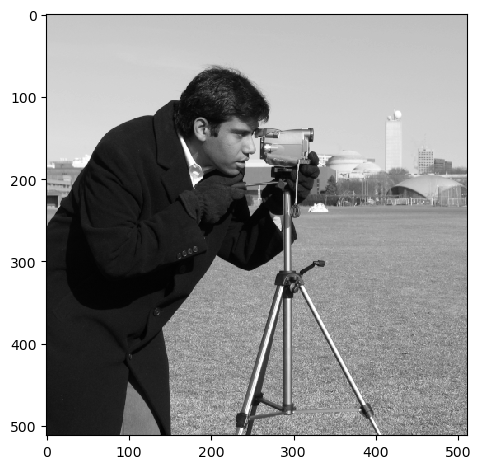

In [4]:
import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.utilities.java
import pathlib
cellprofiler_core.preferences.set_headless()
cellprofiler_core.utilities.java.start_java()
image_set_list = cellprofiler_core.image.ImageSetList()
image_set = image_set_list.get_image_set(0)
import skimage.data
x = skimage.data.camera()
image_x = cellprofiler_core.image.Image(x)
image_set.add("x", image_x)
skimage.io.imshow(image_set.get_image("x").pixel_data)
object_set = cellprofiler_core.object.ObjectSet()
objects  = cellprofiler_core.object.Objects()
object_set.add_objects(objects, "example")
measurements = cellprofiler_core.measurement.Measurements()
pipeline = cellprofiler_core.pipeline.Pipeline()


#### Set up Cellpose module 

Before running the code, make sure that cellpose module is imported to the cellprofiler directory so that it can be loaded.

To properlly set up cellpose module inside of the given cellprofiler pipeline, cellpose module should not be within the pipeline. 

In a given pipeline, delete the cellpose module, but make a note about the number of cellpose modules so that you can re-insert in here. 

To insert cellpose module, you need a module number, which is the location of the module in a pipeline, indicted by <code style="background:grey;color:white">module.module_num</code>. You can check if the module is been properly inserted by print our the modules using ```pipeline.modules()```.


In [5]:
import cellprofiler.modules.saveimages
pipeline.load(cp_pipline)
pipeline.modules()
import cellprofiler.modules.runcellpose
module = cellprofiler.modules.runcellpose.RunCellpose()
#determine where you put the module
module.module_num = 5

c:\Users\CaiLab\anaconda3\envs\ImageAnalysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Add Cellpose Module

In [6]:
pipeline.add_module(module)
# pipeline.modules()[7] = pipeline.modules()[8]
pipeline.modules()
[print(setting.to_dict()) for setting in pipeline.modules()[4].settings()]

{'name': 'cellprofiler_core.setting.subscriber.image_subscriber._image_subscriber.ImageSubscriber', 'text': 'Select the input image', 'value': 'None'}
{'name': 'cellprofiler_core.setting.text.number.integer._integer.Integer', 'text': 'Expected object diameter', 'value': '15'}
{'name': 'cellprofiler_core.setting.choice._choice.Choice', 'text': 'Detection mode', 'value': 'cyto2'}
{'name': 'cellprofiler_core.setting.text.alphanumeric.name._label_name.LabelName', 'text': 'Name the output object', 'value': 'RunCellpose'}
{'name': 'cellprofiler_core.setting._binary.Binary', 'text': 'Use GPU', 'value': 'No'}
{'name': 'cellprofiler_core.setting._binary.Binary', 'text': 'Use averaging', 'value': 'Yes'}
{'name': 'cellprofiler_core.setting._binary.Binary', 'text': 'Supply nuclei image as well?', 'value': 'No'}
{'name': 'cellprofiler_core.setting.subscriber.image_subscriber._image_subscriber.ImageSubscriber', 'text': 'Select the nuclei image', 'value': 'None'}
{'name': 'cellprofiler_core.setting._

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Change cellpose settings
Cellpose module in the pipeline starts with default setting. You can check the default setting using
```[print(setting.to_dict()) for setting in pipeline.modules()[8].settings()]```. The list number is 8 since python starts with 0. 

You can learned your pipeline setting by opening **.cpppl** files. Scrolling down to the RunCellpose module and you can see your settings. Change the default setting to your custom settings. Two settings, <code style="background:grey;color:white">cp_module_dic</code> and <code style="background:grey;color:white">cp_mudole</code> have been set previous, here shown in variables instead of strings. 

In [7]:

pipeline.modules()[4].setting(1).set_value("cells")
pipeline.modules()[4].setting(2).set_value("200")
pipeline.modules()[4].setting(3).set_value("custom")
pipeline.modules()[4].setting(4).set_value("CellposeCell")
pipeline.modules()[4].setting(5).set_value("Yes")
pipeline.modules()[4].setting(6).set_value("Yes")
pipeline.modules()[4].setting(11).set_value(cp_mudole_dic)
pipeline.modules()[4].setting(12).set_value(cp_mudole)
pipeline.modules()[4].setting(21).set_value("No")
[print(setting.to_dict()) for setting in pipeline.modules()[4].settings()]

{'name': 'cellprofiler_core.setting.subscriber.image_subscriber._image_subscriber.ImageSubscriber', 'text': 'Select the input image', 'value': 'cells'}
{'name': 'cellprofiler_core.setting.text.number.integer._integer.Integer', 'text': 'Expected object diameter', 'value': '200'}
{'name': 'cellprofiler_core.setting.choice._choice.Choice', 'text': 'Detection mode', 'value': 'custom'}
{'name': 'cellprofiler_core.setting.text.alphanumeric.name._label_name.LabelName', 'text': 'Name the output object', 'value': 'CellposeCell'}
{'name': 'cellprofiler_core.setting._binary.Binary', 'text': 'Use GPU', 'value': 'Yes'}
{'name': 'cellprofiler_core.setting._binary.Binary', 'text': 'Use averaging', 'value': 'Yes'}
{'name': 'cellprofiler_core.setting._binary.Binary', 'text': 'Supply nuclei image as well?', 'value': 'No'}
{'name': 'cellprofiler_core.setting.subscriber.image_subscriber._image_subscriber.ImageSubscriber', 'text': 'Select the nuclei image', 'value': 'None'}
{'name': 'cellprofiler_core.sett

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Run cell profiler. Input mask files have been indicated previous and stored in <code style="background:grey;color:white">maskoutput</code> folder.

In [8]:
import os
folder_name = 'maskoutput'
if not os.path.isdir(folder_name):
    os.makedirs(folder_name)
current_dir = pathlib.Path().absolute()
cellprofiler_core.preferences.set_default_output_directory(folder_name)
file_list = list(pathlib.Path('.').absolute().glob('mask\\*.TIF'))
# print(file_list)
files = [file.as_uri() for file in file_list]
pipeline.read_file_list(files)
output_measurements = pipeline.run()

26-Aug-23 15:52:27 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


c:\Users\CaiLab\anaconda3\envs\ImageAnalysis\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 10 fits in uint8
  return _convert(image, np.uint8, force_copy)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: maskoutput\230709_63-02-Airyscan Processing-07_.czi.S001.T001.P26-A1.omemask.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
c:\Users\CaiLab\anaconda3\envs\ImageAnalysis\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 4 fits in uint8
  return _convert(image, np.uint8, force_copy)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: maskoutput\230709_63-02-Airyscan Processing-07_.czi.S002.T001.63-A1.omemask.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
c:\Users\CaiLab\anaconda3\envs\ImageAnalysis\lib\site-packages\s

## Step Three: Reorganize the folder

From previous step, there's mask image in maskoutput folder. Here, i first split all the czi images within the <code style="background:grey;color:white">maskoutput folder</code>. Then I create the  folder for each scene and combine the `.czi `split images within each folder.

The strucutre of the folder would be:

<code style="background:grey;color:white">/maskoutput</code>: initially saving for all reference mask images (first time stamp of all the scenes)

<code style="background:grey;color:white">/maskoutput/_name of the image</code>: a folder that later be created to contain one single mask images and all the split .czi images. 

If start fresh, the directionary is set the same as the script location.  Never run this following 2 times. If needed, add following line before defining file location. 

```os.chdir('c:\\Users\\CaiLab\\Desktop\\CellProfiler.files\\Choon\\230703-09_czi')```

In [9]:
import os
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from pathlib import Path
file_list = [] # create an empty list
for file in mydir.iterdir():
    if file.suffix == '.czi':
        file_list.append(str(file)) # append in files in folder with .tif

#file_list
if not os.path.exists('maskoutput'):
    os.makedirs('maskoutput')
    print("There's no maskoutput folder, check if there's masked images")
for img in file_list: 
    filename = Path(img).stem
    img2 = AICSImage(img) # Open an czi image in file_list
    img_channels = img2.dims.C
    img_scenes = len(img2.scenes)
    img_time = img2.dims.T
    for S in range(img_scenes): #loop through scene by scene (aka positions)
            for C in range(img_channels):
                for T in range(img_time):
                    img2.set_scene(S)# print(S,T,C)
                    single_img_data = img2.get_image_data('ZYX',S=S,T=T,C=C)
                    pos_scene = img2.current_scene
                    if img_channels == 1:#one channel image
                        file_name = f'{filename}_{os.path.splitext(img)[1]}.S{S+1:03d}.T{T+1:03d}.{pos_scene}.ome.tif'
                        OmeTiffWriter.save (single_img_data,f'./maskoutput/{file_name}')
                    if img_channels == 2:#for two channel image, split C1C2
                        file_name = f'{filename}_{os.path.splitext(img)[1]}.S{S+1:03d}.T{T+1:03d}.C{C+1:03d}.ome.tif'
                        OmeTiffWriter.save(single_img_data,f'./maskoutput/{file_name}')
                    elif img_channels == 3:#for three channel image, split C0C1C2
                        file_name = f'{filename}_{os.path.splitext(img)[1]}.S{S:03d}.T{T:03d}.C{C:03d}.ome.tif'
                        OmeTiffWriter.save(single_img_data,f'./maskoutput/{file_name}')

In [11]:

import os
import shutil
os.chdir('c:\\Users\\CaiLab\Desktop\CellProfiler.files\Choon\\230703-09_czi')
print(os.getcwd())
def create_and_move(file, directory_name):
    """If directory doesn't exist, create it and move the file into it."""
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)
    shutil.move(file, directory_name)

def group_files_by_first_letter(path = "."):
    """Group files in the given directory by their first letter."""
    # Change the working directory to the given path
    os.chdir(path)
    print(os.getcwd())
    # List all files in the directory
    files = [f for f in os.listdir(path)]
    print(files)
    #print(files)
    # Group files by their first letter
    for file in files:
        first_letter = file[0:45].upper()
        print(first_letter)
        directory_name = first_letter
        create_and_move(file, directory_name)
# Run the function
if __name__ == '__main__':
    os.chdir('maskoutput')
    directory_path = '.'  # Current directory. You can change this to any path.
    group_files_by_first_letter(directory_path)

c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi
c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput
['230709_63-02-Airyscan Processing-07_.czi.S001.T001.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T001.P26-A1.omemask.tiff', '230709_63-02-Airyscan Processing-07_.czi.S001.T002.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T003.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T004.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T005.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T006.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T007.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T008.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T009.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T010.P26-A1.ome.tif', '230709_63-02-Airyscan Processing-07_.czi.S001.T011.P26-A1.ome.tif', '230709_63-02-Airyscan Proces

## Step Four: Run cellprofiler for each folder

First, change the name and direction of the mask image using <code style="background:grey;color:white">maskchdir</code> and <code style="background:grey;color:white">convert_to_desired_format</code>.

Then, in <code style="background:grey;color:white">runcellprofiler</code>, insert the maskimage direction and run the pipeline. 


In [12]:
import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.utilities.java
import skimage.data
import cellprofiler.modules.saveimages
import os
from urllib.parse import quote
from pathlib import Path

def convert_to_desired_format(original_path):# Convert to forward slashes
    new_path = original_path.replace('\\', '/')# URL encode
    new_path = quote(new_path, safe='/:')# Add 'file:///' prefix and ' 0' suffix
    new_path = 'file:///' + new_path + ' 0'
    return new_path
def maskchdir(imagefolder):
    if imagefolder.is_dir():
        mask_img_dir = Path(imagefolder)
        for mask_img in mask_img_dir.iterdir():
            if "omemask" in mask_img.name:
                # print(mask_img.name)
                mask_img_list = (parent_dic + '/' + str(mask_img))
                mask_img_dict = convert_to_desired_format(mask_img_list)
                print(mask_img_dict)
                return(mask_img_dict)
# #test 
# cppipeline = "cellposecell.cppipe"
# cellprofiler_core.preferences.set_headless()
# cellprofiler_core.utilities.java.start_java()
# image_set_list = cellprofiler_core.image.ImageSetList()#set image list
# image_set = image_set_list.get_image_set(0)
# x = skimage.data.camera()
# image_x = cellprofiler_core.image.Image(x)
# image_set.add("x", image_x)
# skimage.io.imshow(image_set.get_image("x").pixel_data)
# object_set = cellprofiler_core.object.ObjectSet()#set object list
# objects  = cellprofiler_core.object.Objects()
# object_set.add_objects(objects, "example")
# measurements = cellprofiler_core.measurement.Measurements()#set measurement
# pipeline = cellprofiler_core.pipeline.Pipeline()#set pipeline
# pipeline.load(cppipeline)
# pipeline.modules()
# pipeline.modules()[2].setting(20).set_value("mask_img_dict")
# [print(setting.to_dict()) for setting in pipeline.modules()[2].settings()]

26-Aug-23 16:07:00 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN%20PROCESSING-07_.CZI.S001/230709_63-02-Airyscan%20Processing-07_.czi.S001.T001.P26-A1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S001/230709_63-02-Airyscan Processing-07_.czi.S001.T001.P26-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S001/230709_63-02-Airyscan Processing-07_.czi.S001.T002.P26-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S001/230709_63-02-Airyscan Processing-07_.czi.S001.T003.P26-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\trackobjects.py:3271: RuntimeWarning: invalid value encountered in divide
  linearity[has_old] = displacement[has_old] / integrated_distance[has_old]
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\trackobjects.py:3151: RuntimeWarning: invalid value encountered in divide
  linearity[index] = tot_distance / integrated[index]
26-Aug-23 16:12:04 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN%20PROCESSING-07_.CZI.S002/230709_63-02-Airyscan%20Processing-07_.czi.S002.T001.63-A1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S002/230709_63-02-Airyscan Processing-07_.czi.S002.T001.63-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S002/230709_63-02-Airyscan Processing-07_.czi.S002.T002.63-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S002/230709_63-02-Airyscan Processing-07_.czi.S002.T003.63-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S002/23

26-Aug-23 16:16:32 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN%20PROCESSING-07_.CZI.S003/230709_63-02-Airyscan%20Processing-07_.czi.S003.T001.P27-A1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S003/230709_63-02-Airyscan Processing-07_.czi.S003.T001.P27-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S003/230709_63-02-Airyscan Processing-07_.czi.S003.T002.P27-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S003/230709_63-02-Airyscan Processing-07_.czi.S003.T003.P27-A1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_63-02-AIRYSCAN PROCESSING-07_.CZI.S00

26-Aug-23 16:21:12 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN%20PROCESSING-01_.CZI.S001/230709_89-02-Airyscan%20Processing-01_.czi.S001.T001.P6-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S001/230709_89-02-Airyscan Processing-01_.czi.S001.T001.P6-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S001/230709_89-02-Airyscan Processing-01_.czi.S001.T002.P6-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S001/230709_89-02-Airyscan Processing-01_.czi.S001.T003.P6-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S001/23

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\measureobjectsizeshape.py:621: RuntimeWarning: divide by zero encountered in divide
  formfactor = 4.0 * numpy.pi * props["area"] / props["perimeter"] ** 2
C:\Users\CaiLab\centrosome\centrosome\zernike.py:180: RuntimeWarning: invalid value encountered in divide
  ym /= radii[rev_ind]
C:\Users\CaiLab\centrosome\centrosome\zernike.py:183: RuntimeWarning: invalid value encountered in divide
  xm /= radii[rev_ind]
26-Aug-23 16:25:52 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN%20PROCESSING-01_.CZI.S002/230709_89-02-Airyscan%20Processing-01_.czi.S002.T001.89-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S002/230709_89-02-Airyscan Processing-01_.czi.S002.T001.89-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S002/230709_89-02-Airyscan Processing-01_.czi.S002.T002.89-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S002/230709_89-02-Airyscan Processing-01_.czi.S002.T003.89-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S002/23

26-Aug-23 16:31:11 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN%20PROCESSING-01_.CZI.S003/230709_89-02-Airyscan%20Processing-01_.czi.S003.T001.P5-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S003/230709_89-02-Airyscan Processing-01_.czi.S003.T001.P5-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S003/230709_89-02-Airyscan Processing-01_.czi.S003.T002.P5-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S003/230709_89-02-Airyscan Processing-01_.czi.S003.T003.P5-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S003/23

26-Aug-23 16:36:35 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN%20PROCESSING-01_.CZI.S004/230709_89-02-Airyscan%20Processing-01_.czi.S004.T001.P2-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S004/230709_89-02-Airyscan Processing-01_.czi.S004.T001.P2-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S004/230709_89-02-Airyscan Processing-01_.czi.S004.T002.P2-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S004/230709_89-02-Airyscan Processing-01_.czi.S004.T003.P2-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S004/23

26-Aug-23 16:41:27 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN%20PROCESSING-01_.CZI.S005/230709_89-02-Airyscan%20Processing-01_.czi.S005.T001.P3-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S005/230709_89-02-Airyscan Processing-01_.czi.S005.T001.P3-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S005/230709_89-02-Airyscan Processing-01_.czi.S005.T002.P3-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S005/230709_89-02-Airyscan Processing-01_.czi.S005.T003.P3-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S005/23

26-Aug-23 16:46:25 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN%20PROCESSING-01_.CZI.S006/230709_89-02-Airyscan%20Processing-01_.czi.S006.T001.P4-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S006/230709_89-02-Airyscan Processing-01_.czi.S006.T001.P4-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S006/230709_89-02-Airyscan Processing-01_.czi.S006.T002.P4-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S006/230709_89-02-Airyscan Processing-01_.czi.S006.T003.P4-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_89-02-AIRYSCAN PROCESSING-01_.CZI.S006/23

26-Aug-23 16:51:17 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN%20PROCESSING-02_.CZI.S001/230709_90-04-Airyscan%20Processing-02_.czi.S001.T001.P11-A3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001/230709_90-04-Airyscan Processing-02_.czi.S001.T001.P11-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001/230709_90-04-Airyscan Processing-02_.czi.S001.T002.P11-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001/230709_90-04-Airyscan Processing-02_.czi.S001.T003.P11-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001\analysisimage\230709_90-04-Airyscan Processing-02_.czi.S001.T035.P11-A3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001\analysisimage\230709_90-04-Airyscan Processing-02_.czi.S001.T037.P11-A3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S001\analysisimage\230709_90-04-Airyscan Processing-02_.czi.S001.T040.P11-A3.ome.ti

maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN%20PROCESSING-02_.CZI.S002/230709_90-04-Airyscan%20Processing-02_.czi.S002.T001.P10-A3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S002/230709_90-04-Airyscan Processing-02_.czi.S002.T001.P10-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S002/230709_90-04-Airyscan Processing-02_.czi.S002.T002.P10-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S002/230709_90-04-Airyscan Processing-02_.czi.S002.T003.P10-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S00

26-Aug-23 17:02:14 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN%20PROCESSING-02_.CZI.S003/230709_90-04-Airyscan%20Processing-02_.czi.S003.T001.P9-A3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S003/230709_90-04-Airyscan Processing-02_.czi.S003.T001.P9-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S003/230709_90-04-Airyscan Processing-02_.czi.S003.T002.P9-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S003/230709_90-04-Airyscan Processing-02_.czi.S003.T003.P9-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S003/23

26-Aug-23 17:07:20 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN%20PROCESSING-02_.CZI.S004/230709_90-04-Airyscan%20Processing-02_.czi.S004.T001.P7-A3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S004/230709_90-04-Airyscan Processing-02_.czi.S004.T001.P7-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S004/230709_90-04-Airyscan Processing-02_.czi.S004.T002.P7-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S004/230709_90-04-Airyscan Processing-02_.czi.S004.T003.P7-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S004/23

26-Aug-23 17:12:51 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN%20PROCESSING-02_.CZI.S005/230709_90-04-Airyscan%20Processing-02_.czi.S005.T001.90-A3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005/230709_90-04-Airyscan Processing-02_.czi.S005.T001.90-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005/230709_90-04-Airyscan Processing-02_.czi.S005.T002.90-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005/230709_90-04-Airyscan Processing-02_.czi.S005.T003.90-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005/23

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005\analysisimage\230709_90-04-Airyscan Processing-02_.czi.S005.T019.90-A3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005\analysisimage\230709_90-04-Airyscan Processing-02_.czi.S005.T020.90-A3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S005\analysisimage\230709_90-04-Airyscan Processing-02_.czi.S005.T021.90-A3.ome.tiff 

maskoutput\230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN%20PROCESSING-02_.CZI.S006/230709_90-04-Airyscan%20Processing-02_.czi.S006.T001.P8-A3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S006/230709_90-04-Airyscan Processing-02_.czi.S006.T001.P8-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S006/230709_90-04-Airyscan Processing-02_.czi.S006.T002.P8-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S006/230709_90-04-Airyscan Processing-02_.czi.S006.T003.P8-A3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_90-04-AIRYSCAN PROCESSING-02_.CZI.S006/23

26-Aug-23 17:22:58 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN%20PROCESSING-03_.CZI.S001/230709_92-02-Airyscan%20Processing-03_.czi.S001.T001.92-A4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S001/230709_92-02-Airyscan Processing-03_.czi.S001.T001.92-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S001/230709_92-02-Airyscan Processing-03_.czi.S001.T002.92-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S001/230709_92-02-Airyscan Processing-03_.czi.S001.T003.92-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S001/23

26-Aug-23 17:28:21 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN%20PROCESSING-03_.CZI.S002/230709_92-02-Airyscan%20Processing-03_.czi.S002.T001.P12-A4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002/230709_92-02-Airyscan Processing-03_.czi.S002.T001.P12-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002/230709_92-02-Airyscan Processing-03_.czi.S002.T002.P12-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002/230709_92-02-Airyscan Processing-03_.czi.S002.T003.P12-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002\analysisimage\230709_92-02-Airyscan Processing-03_.czi.S002.T030.P12-A4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002\analysisimage\230709_92-02-Airyscan Processing-03_.czi.S002.T031.P12-A4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S002\analysisimage\230709_92-02-Airyscan Processing-03_.czi.S002.T032.P12-A4.ome.ti

maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN%20PROCESSING-03_.CZI.S003/230709_92-02-Airyscan%20Processing-03_.czi.S003.T001.P13-A4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003/230709_92-02-Airyscan Processing-03_.czi.S003.T001.P13-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003/230709_92-02-Airyscan Processing-03_.czi.S003.T002.P13-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003/230709_92-02-Airyscan Processing-03_.czi.S003.T003.P13-A4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003\analysisimage\230709_92-02-Airyscan Processing-03_.czi.S003.T004.P13-A4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003\analysisimage\230709_92-02-Airyscan Processing-03_.czi.S003.T007.P13-A4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_92-02-AIRYSCAN PROCESSING-03_.CZI.S003\analysisimage\230709_92-02-Airyscan Processing-03_.czi.S003.T008.P13-A4.ome.ti

maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN%20PROCESSING-06_.CZI.S001/230709_93-02-Airyscan%20Processing-06_.czi.S001.T001.P25-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S001/230709_93-02-Airyscan Processing-06_.czi.S001.T001.P25-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S001/230709_93-02-Airyscan Processing-06_.czi.S001.T002.P25-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S001/230709_93-02-Airyscan Processing-06_.czi.S001.T003.P25-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S00

26-Aug-23 17:44:00 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN%20PROCESSING-06_.CZI.S002/230709_93-02-Airyscan%20Processing-06_.czi.S002.T001.P24-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002/230709_93-02-Airyscan Processing-06_.czi.S002.T001.P24-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002/230709_93-02-Airyscan Processing-06_.czi.S002.T002.P24-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002/230709_93-02-Airyscan Processing-06_.czi.S002.T003.P24-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002\analysisimage\230709_93-02-Airyscan Processing-06_.czi.S002.T036.P24-B2.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002\analysisimage\230709_93-02-Airyscan Processing-06_.czi.S002.T038.P24-B2.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S002\analysisimage\230709_93-02-Airyscan Processing-06_.czi.S002.T040.P24-B2.ome.ti

maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN%20PROCESSING-06_.CZI.S003/230709_93-02-Airyscan%20Processing-06_.czi.S003.T001.93-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003/230709_93-02-Airyscan Processing-06_.czi.S003.T001.93-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003/230709_93-02-Airyscan Processing-06_.czi.S003.T002.93-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003/230709_93-02-Airyscan Processing-06_.czi.S003.T003.93-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003/23

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003\analysisimage\230709_93-02-Airyscan Processing-06_.czi.S003.T028.93-B2.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003\analysisimage\230709_93-02-Airyscan Processing-06_.czi.S003.T029.93-B2.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_93-02-AIRYSCAN PROCESSING-06_.CZI.S003\analysisimage\230709_93-02-Airyscan Processing-06_.czi.S003.T030.93-B2.ome.tiff 

maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN%20PROCESSING-05_.CZI.S001/230709_94-02-Airyscan%20Processing-05_.czi.S001.T001.94-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001/230709_94-02-Airyscan Processing-05_.czi.S001.T001.94-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001/230709_94-02-Airyscan Processing-05_.czi.S001.T002.94-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001/230709_94-02-Airyscan Processing-05_.czi.S001.T003.94-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001/23

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S001.T021.94-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S001.T022.94-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S001\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S001.T024.94-B3.ome.tiff 

maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN%20PROCESSING-05_.CZI.S002/230709_94-02-Airyscan%20Processing-05_.czi.S002.T001.P20-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S002/230709_94-02-Airyscan Processing-05_.czi.S002.T001.P20-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S002/230709_94-02-Airyscan Processing-05_.czi.S002.T002.P20-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S002/230709_94-02-Airyscan Processing-05_.czi.S002.T003.P20-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S00

26-Aug-23 18:05:01 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN%20PROCESSING-05_.CZI.S003/230709_94-02-Airyscan%20Processing-05_.czi.S003.T001.P19-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S003/230709_94-02-Airyscan Processing-05_.czi.S003.T001.P19-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S003/230709_94-02-Airyscan Processing-05_.czi.S003.T002.P19-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S003/230709_94-02-Airyscan Processing-05_.czi.S003.T003.P19-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S00

26-Aug-23 18:10:18 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN%20PROCESSING-05_.CZI.S004/230709_94-02-Airyscan%20Processing-05_.czi.S004.T001.P23-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S004/230709_94-02-Airyscan Processing-05_.czi.S004.T001.P23-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S004/230709_94-02-Airyscan Processing-05_.czi.S004.T002.P23-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S004/230709_94-02-Airyscan Processing-05_.czi.S004.T003.P23-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S00

26-Aug-23 18:15:07 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN%20PROCESSING-05_.CZI.S005/230709_94-02-Airyscan%20Processing-05_.czi.S005.T001.P22-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005/230709_94-02-Airyscan Processing-05_.czi.S005.T001.P22-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005/230709_94-02-Airyscan Processing-05_.czi.S005.T002.P22-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005/230709_94-02-Airyscan Processing-05_.czi.S005.T003.P22-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S005.T021.P22-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S005.T022.P22-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S005\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S005.T023.P22-B3.ome.ti

maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN%20PROCESSING-05_.CZI.S006/230709_94-02-Airyscan%20Processing-05_.czi.S006.T001.P21-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006/230709_94-02-Airyscan Processing-05_.czi.S006.T001.P21-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006/230709_94-02-Airyscan Processing-05_.czi.S006.T002.P21-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006/230709_94-02-Airyscan Processing-05_.czi.S006.T003.P21-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S006.T013.P21-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S006.T014.P21-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_94-02-AIRYSCAN PROCESSING-05_.CZI.S006\analysisimage\230709_94-02-Airyscan Processing-05_.czi.S006.T017.P21-B3.ome.ti

maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN%20PROCESSING-04_.CZI.S001/230709_95-02-Airyscan%20Processing-04_.czi.S001.T001.95-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001/230709_95-02-Airyscan Processing-04_.czi.S001.T001.95-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001/230709_95-02-Airyscan Processing-04_.czi.S001.T002.95-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001/230709_95-02-Airyscan Processing-04_.czi.S001.T003.95-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001/23

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S001.T014.95-B4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S001.T016.95-B4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S001\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S001.T018.95-B4.ome.tiff 

maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN%20PROCESSING-04_.CZI.S002/230709_95-02-Airyscan%20Processing-04_.czi.S002.T001.P14-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002/230709_95-02-Airyscan Processing-04_.czi.S002.T001.P14-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002/230709_95-02-Airyscan Processing-04_.czi.S002.T002.P14-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002/230709_95-02-Airyscan Processing-04_.czi.S002.T003.P14-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S002.T023.P14-B4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S002.T024.P14-B4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S002\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S002.T036.P14-B4.ome.ti

maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN%20PROCESSING-04_.CZI.S003/230709_95-02-Airyscan%20Processing-04_.czi.S003.T001.P15-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S003/230709_95-02-Airyscan Processing-04_.czi.S003.T001.P15-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S003/230709_95-02-Airyscan Processing-04_.czi.S003.T002.P15-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S003/230709_95-02-Airyscan Processing-04_.czi.S003.T003.P15-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 18:40:36 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN%20PROCESSING-04_.CZI.S004/230709_95-02-Airyscan%20Processing-04_.czi.S004.T001.P16-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004/230709_95-02-Airyscan Processing-04_.czi.S004.T001.P16-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004/230709_95-02-Airyscan Processing-04_.czi.S004.T002.P16-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004/230709_95-02-Airyscan Processing-04_.czi.S004.T003.P16-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S004.T030.P16-B4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S004.T034.P16-B4.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S004\analysisimage\230709_95-02-Airyscan Processing-04_.czi.S004.T035.P16-B4.ome.ti

maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN%20PROCESSING-04_.CZI.S005/230709_95-02-Airyscan%20Processing-04_.czi.S005.T001.P17-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S005/230709_95-02-Airyscan Processing-04_.czi.S005.T001.P17-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S005/230709_95-02-Airyscan Processing-04_.czi.S005.T002.P17-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S005/230709_95-02-Airyscan Processing-04_.czi.S005.T003.P17-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 18:51:58 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN%20PROCESSING-04_.CZI.S006/230709_95-02-Airyscan%20Processing-04_.czi.S006.T001.P18-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S006/230709_95-02-Airyscan Processing-04_.czi.S006.T001.P18-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S006/230709_95-02-Airyscan Processing-04_.czi.S006.T002.P18-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S006/230709_95-02-Airyscan Processing-04_.czi.S006.T003.P18-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230709_95-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 18:57:30 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN%20PROCESSING-01_.CZI.S001/230712_91-02-Airyscan%20Processing-01_.czi.S001.T001.91-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S001/230712_91-02-Airyscan Processing-01_.czi.S001.T001.91-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S001/230712_91-02-Airyscan Processing-01_.czi.S001.T002.91-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S001/230712_91-02-Airyscan Processing-01_.czi.S001.T003.91-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S001/23

26-Aug-23 19:02:29 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN%20PROCESSING-01_.CZI.S002/230712_91-02-Airyscan%20Processing-01_.czi.S002.T001.P2-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S002/230712_91-02-Airyscan Processing-01_.czi.S002.T001.P2-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S002/230712_91-02-Airyscan Processing-01_.czi.S002.T002.P2-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S002/230712_91-02-Airyscan Processing-01_.czi.S002.T003.P2-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S002/23

26-Aug-23 19:07:26 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN%20PROCESSING-01_.CZI.S003/230712_91-02-Airyscan%20Processing-01_.czi.S003.T001.P3-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S003/230712_91-02-Airyscan Processing-01_.czi.S003.T001.P3-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S003/230712_91-02-Airyscan Processing-01_.czi.S003.T002.P3-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S003/230712_91-02-Airyscan Processing-01_.czi.S003.T003.P3-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S003/23

26-Aug-23 19:12:28 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN%20PROCESSING-01_.CZI.S004/230712_91-02-Airyscan%20Processing-01_.czi.S004.T001.P4-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S004/230712_91-02-Airyscan Processing-01_.czi.S004.T001.P4-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S004/230712_91-02-Airyscan Processing-01_.czi.S004.T002.P4-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S004/230712_91-02-Airyscan Processing-01_.czi.S004.T003.P4-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S004/23

26-Aug-23 19:17:24 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN%20PROCESSING-01_.CZI.S005/230712_91-02-Airyscan%20Processing-01_.czi.S005.T001.P5-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S005/230712_91-02-Airyscan Processing-01_.czi.S005.T001.P5-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S005/230712_91-02-Airyscan Processing-01_.czi.S005.T002.P5-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S005/230712_91-02-Airyscan Processing-01_.czi.S005.T003.P5-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S005/23

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S005\analysisimage\230712_91-02-Airyscan Processing-01_.czi.S005.T007.P5-A2.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
26-Aug-23 19:22:18 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN%20PROCESSING-01_.CZI.S006/230712_91-02-Airyscan%20Processing-01_.czi.S006.T001.P6-A2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S006/230712_91-02-Airyscan Processing-01_.czi.S006.T001.P6-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S006/230712_91-02-Airyscan Processing-01_.czi.S006.T002.P6-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S006/230712_91-02-Airyscan Processing-01_.czi.S006.T003.P6-A2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_91-02-AIRYSCAN PROCESSING-01_.CZI.S006/23

26-Aug-23 19:27:10 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN%20PROCESSING-07_.CZI.S001/230712_96-02-Airyscan%20Processing-07_.czi.S001.T001.P30-B1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S001/230712_96-02-Airyscan Processing-07_.czi.S001.T001.P30-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S001/230712_96-02-Airyscan Processing-07_.czi.S001.T002.P30-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S001/230712_96-02-Airyscan Processing-07_.czi.S001.T003.P30-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S00

26-Aug-23 19:32:09 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN%20PROCESSING-07_.CZI.S002/230712_96-02-Airyscan%20Processing-07_.czi.S002.T001.P27-B1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S002/230712_96-02-Airyscan Processing-07_.czi.S002.T001.P27-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S002/230712_96-02-Airyscan Processing-07_.czi.S002.T002.P27-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S002/230712_96-02-Airyscan Processing-07_.czi.S002.T003.P27-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\measureobjectintensity.py:441: RuntimeWarning: invalid value encountered in divide
  cmi_x[lindexes - 1] = i_x / integrated_intensity[lindexes - 1]
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\measureobjectintensity.py:442: RuntimeWarning: invalid value encountered in divide
  cmi_y[lindexes - 1] = i_y / integrated_intensity[lindexes - 1]
C:\Users\CaiLab\CellProfiler\cellprofiler\modules\measureobjectintensity.py:443: RuntimeWarning: invalid value encountered in divide
  cmi_z[lindexes - 1] = i_z / integrated_intensity[lindexes - 1]
26-Aug-23 19:36:58 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN%20PROCESSING-07_.CZI.S003/230712_96-02-Airyscan%20Processing-07_.czi.S003.T001.96-B1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S003/230712_96-02-Airyscan Processing-07_.czi.S003.T001.96-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S003/230712_96-02-Airyscan Processing-07_.czi.S003.T002.96-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S003/230712_96-02-Airyscan Processing-07_.czi.S003.T003.96-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S003/23

26-Aug-23 19:42:06 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN%20PROCESSING-07_.CZI.S004/230712_96-02-Airyscan%20Processing-07_.czi.S004.T001.P29-B1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S004/230712_96-02-Airyscan Processing-07_.czi.S004.T001.P29-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S004/230712_96-02-Airyscan Processing-07_.czi.S004.T002.P29-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S004/230712_96-02-Airyscan Processing-07_.czi.S004.T003.P29-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S00

26-Aug-23 19:47:23 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN%20PROCESSING-07_.CZI.S005/230712_96-02-Airyscan%20Processing-07_.czi.S005.T001.P28-B1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S005/230712_96-02-Airyscan Processing-07_.czi.S005.T001.P28-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S005/230712_96-02-Airyscan Processing-07_.czi.S005.T002.P28-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S005/230712_96-02-Airyscan Processing-07_.czi.S005.T003.P28-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S00

26-Aug-23 19:52:20 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN%20PROCESSING-07_.CZI.S006/230712_96-02-Airyscan%20Processing-07_.czi.S006.T001.P31-B1.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S006/230712_96-02-Airyscan Processing-07_.czi.S006.T001.P31-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S006/230712_96-02-Airyscan Processing-07_.czi.S006.T002.P31-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S006/230712_96-02-Airyscan Processing-07_.czi.S006.T003.P31-B1.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_96-02-AIRYSCAN PROCESSING-07_.CZI.S00

26-Aug-23 19:57:43 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN%20PROCESSING-06_.CZI.S001/230712_97-02-Airyscan%20Processing-06_.czi.S001.T001.P23-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S001/230712_97-02-Airyscan Processing-06_.czi.S001.T001.P23-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S001/230712_97-02-Airyscan Processing-06_.czi.S001.T002.P23-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S001/230712_97-02-Airyscan Processing-06_.czi.S001.T003.P23-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S00

26-Aug-23 20:03:14 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN%20PROCESSING-06_.CZI.S002/230712_97-02-Airyscan%20Processing-06_.czi.S002.T001.P1-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S002/230712_97-02-Airyscan Processing-06_.czi.S002.T001.P1-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S002/230712_97-02-Airyscan Processing-06_.czi.S002.T002.P1-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S002/230712_97-02-Airyscan Processing-06_.czi.S002.T003.P1-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S002/23

26-Aug-23 20:08:14 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN%20PROCESSING-06_.CZI.S003/230712_97-02-Airyscan%20Processing-06_.czi.S003.T001.P25-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S003/230712_97-02-Airyscan Processing-06_.czi.S003.T001.P25-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S003/230712_97-02-Airyscan Processing-06_.czi.S003.T002.P25-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S003/230712_97-02-Airyscan Processing-06_.czi.S003.T003.P25-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S00

26-Aug-23 20:13:32 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN%20PROCESSING-06_.CZI.S004/230712_97-02-Airyscan%20Processing-06_.czi.S004.T001.P24-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S004/230712_97-02-Airyscan Processing-06_.czi.S004.T001.P24-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S004/230712_97-02-Airyscan Processing-06_.czi.S004.T002.P24-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S004/230712_97-02-Airyscan Processing-06_.czi.S004.T003.P24-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S00

26-Aug-23 20:19:03 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN%20PROCESSING-06_.CZI.S005/230712_97-02-Airyscan%20Processing-06_.czi.S005.T001.P22-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S005/230712_97-02-Airyscan Processing-06_.czi.S005.T001.P22-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S005/230712_97-02-Airyscan Processing-06_.czi.S005.T002.P22-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S005/230712_97-02-Airyscan Processing-06_.czi.S005.T003.P22-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S00

26-Aug-23 20:24:20 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN%20PROCESSING-06_.CZI.S006/230712_97-02-Airyscan%20Processing-06_.czi.S006.T001.P21-B2.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S006/230712_97-02-Airyscan Processing-06_.czi.S006.T001.P21-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S006/230712_97-02-Airyscan Processing-06_.czi.S006.T002.P21-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S006/230712_97-02-Airyscan Processing-06_.czi.S006.T003.P21-B2.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_97-02-AIRYSCAN PROCESSING-06_.CZI.S00

26-Aug-23 20:29:55 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN%20PROCESSING-05_.CZI.S001/230712_98-02-Airyscan%20Processing-05_.czi.S001.T001.98-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S001/230712_98-02-Airyscan Processing-05_.czi.S001.T001.98-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S001/230712_98-02-Airyscan Processing-05_.czi.S001.T002.98-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S001/230712_98-02-Airyscan Processing-05_.czi.S001.T003.98-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S001/23

26-Aug-23 20:35:22 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN%20PROCESSING-05_.CZI.S002/230712_98-02-Airyscan%20Processing-05_.czi.S002.T001.P17-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S002/230712_98-02-Airyscan Processing-05_.czi.S002.T001.P17-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S002/230712_98-02-Airyscan Processing-05_.czi.S002.T002.P17-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S002/230712_98-02-Airyscan Processing-05_.czi.S002.T003.P17-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S002\analysisimage\230712_98-02-Airyscan Processing-05_.czi.S002.T002.P17-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
26-Aug-23 20:40:25 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN%20PROCESSING-05_.CZI.S003/230712_98-02-Airyscan%20Processing-05_.czi.S003.T001.P16-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S003/230712_98-02-Airyscan Processing-05_.czi.S003.T001.P16-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S003/230712_98-02-Airyscan Processing-05_.czi.S003.T002.P16-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S003/230712_98-02-Airyscan Processing-05_.czi.S003.T003.P16-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S00

C:\Users\CaiLab\CellProfiler\cellprofiler\modules\saveimages.py:795: UserWarning: c:\Users\CaiLab\Desktop\CellProfiler.files\Choon\230703-09_czi\maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S003\analysisimage\230712_98-02-Airyscan Processing-05_.czi.S003.T002.P16-B3.ome.tiff is a low contrast image
  skimage.io.imsave(filename, pixels, **save_kwargs)
26-Aug-23 20:46:10 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN%20PROCESSING-05_.CZI.S004/230712_98-02-Airyscan%20Processing-05_.czi.S004.T001.P18-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S004/230712_98-02-Airyscan Processing-05_.czi.S004.T001.P18-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S004/230712_98-02-Airyscan Processing-05_.czi.S004.T002.P18-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S004/230712_98-02-Airyscan Processing-05_.czi.S004.T003.P18-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S00

26-Aug-23 20:51:27 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN%20PROCESSING-05_.CZI.S005/230712_98-02-Airyscan%20Processing-05_.czi.S005.T001.P19-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S005/230712_98-02-Airyscan Processing-05_.czi.S005.T001.P19-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S005/230712_98-02-Airyscan Processing-05_.czi.S005.T002.P19-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S005/230712_98-02-Airyscan Processing-05_.czi.S005.T003.P19-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S00

26-Aug-23 20:56:33 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN%20PROCESSING-05_.CZI.S006/230712_98-02-Airyscan%20Processing-05_.czi.S006.T001.P20-B3.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S006/230712_98-02-Airyscan Processing-05_.czi.S006.T001.P20-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S006/230712_98-02-Airyscan Processing-05_.czi.S006.T002.P20-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S006/230712_98-02-Airyscan Processing-05_.czi.S006.T003.P20-B3.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_98-02-AIRYSCAN PROCESSING-05_.CZI.S00

26-Aug-23 21:02:27 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S001
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN%20PROCESSING-04_.CZI.S001/230712_99-02-Airyscan%20Processing-04_.czi.S001.T001.99-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S001/230712_99-02-Airyscan Processing-04_.czi.S001.T001.99-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S001/230712_99-02-Airyscan Processing-04_.czi.S001.T002.99-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S001/230712_99-02-Airyscan Processing-04_.czi.S001.T003.99-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S001/23

26-Aug-23 21:07:57 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S002
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN%20PROCESSING-04_.CZI.S002/230712_99-02-Airyscan%20Processing-04_.czi.S002.T001.P11-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S002/230712_99-02-Airyscan Processing-04_.czi.S002.T001.P11-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S002/230712_99-02-Airyscan Processing-04_.czi.S002.T002.P11-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S002/230712_99-02-Airyscan Processing-04_.czi.S002.T003.P11-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 21:13:13 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S003
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN%20PROCESSING-04_.CZI.S003/230712_99-02-Airyscan%20Processing-04_.czi.S003.T001.P13-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S003/230712_99-02-Airyscan Processing-04_.czi.S003.T001.P13-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S003/230712_99-02-Airyscan Processing-04_.czi.S003.T002.P13-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S003/230712_99-02-Airyscan Processing-04_.czi.S003.T003.P13-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 21:18:27 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S004
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN%20PROCESSING-04_.CZI.S004/230712_99-02-Airyscan%20Processing-04_.czi.S004.T001.P12-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S004/230712_99-02-Airyscan Processing-04_.czi.S004.T001.P12-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S004/230712_99-02-Airyscan Processing-04_.czi.S004.T002.P12-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S004/230712_99-02-Airyscan Processing-04_.czi.S004.T003.P12-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 21:23:22 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S005
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN%20PROCESSING-04_.CZI.S005/230712_99-02-Airyscan%20Processing-04_.czi.S005.T001.P14-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S005/230712_99-02-Airyscan Processing-04_.czi.S005.T001.P14-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S005/230712_99-02-Airyscan Processing-04_.czi.S005.T002.P14-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S005/230712_99-02-Airyscan Processing-04_.czi.S005.T003.P14-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S00

26-Aug-23 21:28:41 - cellprofiler_core.modules.images - WARNING  - Workspace file list is empty, will populate from pipeline.This may happen if you're running in headless mode.


maskoutput\230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S006
file:///c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN%20PROCESSING-04_.CZI.S006/230712_99-02-Airyscan%20Processing-04_.czi.S006.T001.P15-B4.omemask.tiff 0
[WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S006/230712_99-02-Airyscan Processing-04_.czi.S006.T001.P15-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S006/230712_99-02-Airyscan Processing-04_.czi.S006.T002.P15-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S006/230712_99-02-Airyscan Processing-04_.czi.S006.T003.P15-B4.ome.tif'), WindowsPath('c:/Users/CaiLab/Desktop/CellProfiler.files/Choon/230703-09_czi/maskoutput/230712_99-02-AIRYSCAN PROCESSING-04_.CZI.S00

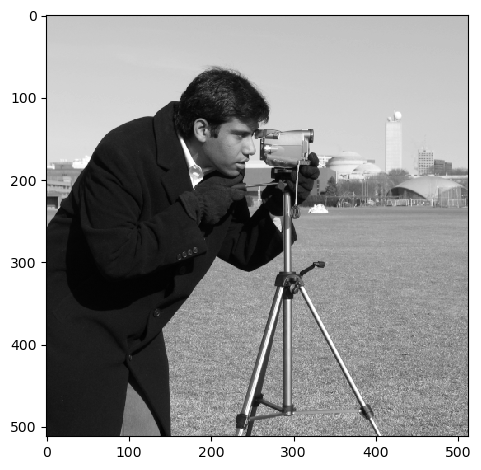

In [13]:

def runcellprofiler(cppipeline, imagefolder):
    cellprofiler_core.preferences.set_headless()
    cellprofiler_core.utilities.java.start_java()
    image_set_list = cellprofiler_core.image.ImageSetList()#set image list
    image_set = image_set_list.get_image_set(0)
    x = skimage.data.camera()
    image_x = cellprofiler_core.image.Image(x)
    image_set.add("x", image_x)
    skimage.io.imshow(image_set.get_image("x").pixel_data)
    object_set = cellprofiler_core.object.ObjectSet()#set object list
    objects  = cellprofiler_core.object.Objects()
    object_set.add_objects(objects, "example")
    measurements = cellprofiler_core.measurement.Measurements()#set measurement
    pipeline = cellprofiler_core.pipeline.Pipeline()#set pipeline
    pipeline.load(cppipeline)
    pipeline.modules()
    # folder_name = 'output'
    # if not os.path.isdir(folder_name):
    #     os.makedirs(folder_name)
    mask_img_dict = maskchdir(imagefolder)
    pipeline.modules()[2].setting(20).set_value(mask_img_dict)
    # [print(setting.to_dict()) for setting in pipeline.modules()[2].settings()]
    current_dir = pathlib.Path().absolute()
    cellprofiler_core.preferences.set_default_output_directory(imagefolder)
    file_list = list(pathlib.Path('.').absolute().glob(str(imagefolder) + '\\*.TIF'))
    print(file_list)
    files = [file.as_uri() for file in file_list]
    pipeline.read_file_list(files)
    output_measurements = pipeline.run()

os.chdir(parent_dic)
outputdir = Path("maskoutput/")
for folder in outputdir.iterdir():
    print(folder)
    runcellprofiler("cellposecell.cppipe", folder)

## Step Five 
You can directly get the output_measures by python, followed by data analysis.

In [13]:
output_measurements.get_measurement_columns()

[('CellposeCell', 'AreaShape_Area', 'float'),
 ('CellposeCell', 'AreaShape_BoundingBoxArea', 'float'),
 ('CellposeCell', 'AreaShape_BoundingBoxMaximum_X', 'integer'),
 ('CellposeCell', 'AreaShape_BoundingBoxMaximum_Y', 'integer'),
 ('CellposeCell', 'AreaShape_BoundingBoxMinimum_X', 'integer'),
 ('CellposeCell', 'AreaShape_BoundingBoxMinimum_Y', 'integer'),
 ('CellposeCell', 'AreaShape_Center_X', 'float'),
 ('CellposeCell', 'AreaShape_Center_Y', 'float'),
 ('CellposeCell', 'AreaShape_Compactness', 'float'),
 ('CellposeCell', 'AreaShape_ConvexArea', 'float'),
 ('CellposeCell', 'AreaShape_Eccentricity', 'float'),
 ('CellposeCell', 'AreaShape_EquivalentDiameter', 'float'),
 ('CellposeCell', 'AreaShape_EulerNumber', 'integer'),
 ('CellposeCell', 'AreaShape_Extent', 'float'),
 ('CellposeCell', 'AreaShape_FormFactor', 'float'),
 ('CellposeCell', 'AreaShape_MajorAxisLength', 'float'),
 ('CellposeCell', 'AreaShape_MaxFeretDiameter', 'float'),
 ('CellposeCell', 'AreaShape_MaximumRadius', 'float'

In [14]:

output_measurements.get_measurement('CellposeCell', 'Children_IdentifyPrimaryObjects_Count')

array([  0,  65, 276,   3,   0,   0,  23,  67,  21], dtype=int64)